# BSREM

## Preliminaries

The following tutorial is an introduction to reconstruction using the BSREM algorithm. It is recommended that you first go through the `SPECT: Bayesian Priors` tutorial first.

In [1]:
import os
from pytomography.io.SPECT import simind
from pytomography.priors import RelativeDifferencePrior
from pytomography.projectors import SPECTSystemMatrix
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import BSREM
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from torch import poisson
import torch
import matplotlib.pyplot as plt
from pytomography.callbacks import LogLikelihoodCallback

Let's set the random seed. This is important because (i) random numbers are used when generating the projection data (ii) slight variations in projection data can change convergence to maximum liklihood for different relaxation sequences in BSREM.

In [2]:
torch.manual_seed(1)

Modify the following path to the directory where you saved the tutorial data:

In [3]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/'

The first cell of code is borrowed from the `SPECT: Reconstructing SIMIND Data` tutorial in the multiple regions case. For a more comprehensive description about the code below, please see that tutorial.

In [4]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
object_meta, proj_meta = simind.get_metadata(headerfiles[0]) #assumes the same for all
photopeak = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)
# Convert from CPS to counts
dT = 15 #s
photopeak *= dT
scatter *= dT
photopeak_poisson = poisson(photopeak)
scatter_poisson = poisson(scatter)
# Obtain required transforms to build system matrix
attenuation_map = simind.get_attenuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta,
    n_parallel=8)

## The Algorithm

The BSREM reconstruction algorithm can be expressed as

$$\hat{f}^{n,m+1} = \hat{f}^{n,m} + \alpha_n D \left[H_m^T \left(\frac{g_m}{H_m \hat{f}^{n,m} + s} -1 \right) - \beta \nabla_{f^{n,m}} V \right]$$

which corresponds to to Modified BSREM-II with $U=\infty$, $t=0$, and $\epsilon=0$ (see https://ieeexplore.ieee.org/document/1207396).

There are lots of hyperparameters to consider:

1. The sequence $\alpha_n$, also known as the "relaxation sequence"
2. The scaling matrix $D$, used scale gradient-based updates to the object estimate
3. The prior function $V$, and any associated hyperparameters of that function.
4. The number of iterations/subsets used

As was done in the Bayesian priors tutorial (you should go through that tutorial before this one), lets define a bunch of different priors

In [5]:
# Euclidean weights
prior_rdp = RelativeDifferencePrior(beta=0.3, gamma=2)
# Anatomical weights
weight_top8anatomy = TopNAnatomyNeighbourWeight(attenuation_map, N_neighbours=8)
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)

The function below is used to reconstruct the images. The arguments correspond to all the parameters specified above. We'll also use the `LogLiklihoodCallback` class to track the log-liklihood after each iteration (this will allow us to compare different $\alpha_n$, number of subsets, and scaling matrix $D$)

In [6]:
def reconstruct(
    prior = None,
    n_iters=40,
    n_subsets=8,
    relaxation_function=lambda n: 1,
    scaling_matrix_type='subind_norm'
):   
    # Use a logliklihood callback to track liklihood after each iteration
    cb = LogLikelihoodCallback(photopeak_poisson, system_matrix, prior=prior)
    # Reconstruct
    reconstruction_algorithm = BSREM(
    projections = photopeak_poisson,
    system_matrix = system_matrix,
    scatter = scatter_poisson,
    prior=prior,
    relaxation_function=relaxation_function,
    scaling_matrix_type=scaling_matrix_type)
    return reconstruction_algorithm(n_iters, n_subsets, callback=cb), cb

First, lets compare using an "unrelaxed" ($\alpha_n=1$) vs. a "relaxed" ($\alpha_n=1/(n/50+1)$) sequence:

* Note: each reconstruction takes around 3 minutes (Tesla V100 GPU)

In [7]:
recon_unrelaxed, cb_unrelaxed = reconstruct(relaxation_function=lambda n: 1, n_subsets=16, prior=prior_rdp)
recon_relaxed, cb_relaxed = reconstruct(relaxation_function=lambda n: 1/(n/50+1), n_subsets=16, prior=prior_rdp)

View the reconstructions:

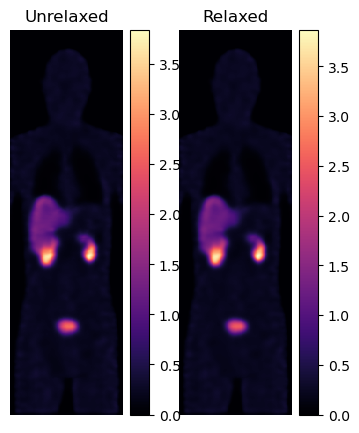

In [8]:
plt.subplots(1,2,figsize=(4,5))
plt.subplot(121)
plt.pcolormesh(recon_unrelaxed[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Unrelaxed')
plt.subplot(122)
plt.pcolormesh(recon_relaxed[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Relaxed')
plt.show()

They don't look all that different, but let's compare the log-liklihoods:

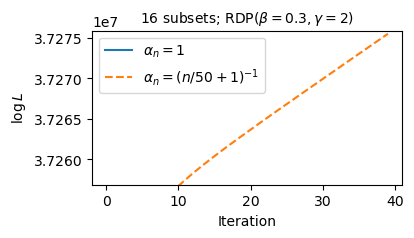

In [9]:
plt.figure(figsize=(4,2))
plt.plot(cb_unrelaxed.liklihoods, label=r'$\alpha_n=1$')
plt.plot(cb_relaxed.liklihoods, ls='--', label=r'$\alpha_n=(n/50+1)^{-1}$')
plt.ylim(bottom=0.9995*max(cb_relaxed.liklihoods), top=1.00001*max(cb_relaxed.liklihoods))
plt.xlabel('Iteration')
plt.ylabel('$\log L$')
plt.title(r'16 subsets; RDP($\beta=0.3, \gamma=2$)', fontsize=10)
plt.legend()
plt.show()

Use of relaxation allows the algorithm to converge to larger log-liklihood values and avoid the so-called "limit cycle" incurred by using $\alpha_n=1$.

* **Important note**: This does not necessarily hold for repeated experiments/different projection data. In some cases, use of a relaxation sequence tends to make the log-liklihood decrease in subsequent iterations. This can be seen by changing `torch.manual_seed(2)` in the cell at the beginning.

Let's perform the same analysis using RDP but with anatomical weights:

In [10]:
recon_ap_unrelaxed, cb_ap_unrelaxed = reconstruct(relaxation_function=lambda n: 1, n_subsets=16, prior=prior_rdpap)
recon_ap_relaxed, cb_ap_relaxed = reconstruct(relaxation_function=lambda n: 1/(n/50+1), n_subsets=16, prior=prior_rdpap)

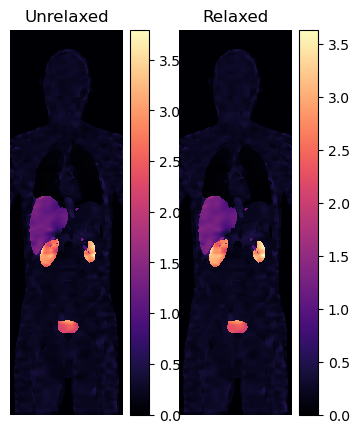

In [11]:
plt.subplots(1,2,figsize=(4,5))
plt.subplot(121)
plt.pcolormesh(recon_ap_unrelaxed[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Unrelaxed')
plt.subplot(122)
plt.pcolormesh(recon_ap_relaxed[0].cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Relaxed')
plt.show()

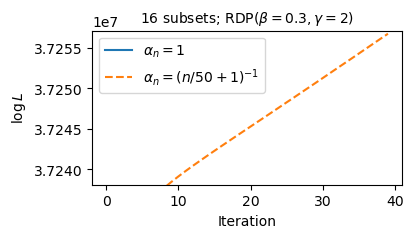

In [12]:
plt.figure(figsize=(4,2))
plt.plot(cb_ap_unrelaxed.liklihoods, label=r'$\alpha_n=1$')
plt.plot(cb_ap_relaxed.liklihoods, ls='--', label=r'$\alpha_n=(n/50+1)^{-1}$')
plt.ylim(bottom=0.9995*max(cb_ap_relaxed.liklihoods), top=1.00001*max(cb_ap_relaxed.liklihoods))
plt.xlabel('Iteration')
plt.ylabel('$\log L$')
plt.title(r'16 subsets; RDP($\beta=0.3, \gamma=2$)', fontsize=10)
plt.legend()
plt.show()